X_train: (15362160, 2) | #train files: 60
#test files: 3
[KMeans] Fitting on 15362160 samples, dim=2, K=3, n_init=5
[KMeans] Run 1/5
[KMeans] k-means++ init for K=3 ...
[KMeans] init centers ready.
[KMeans] iter   0 inertia=2681579079.892661
[KMeans] iter  10 inertia=1033062875.553635
[KMeans] iter  20 inertia=1029787603.538781
[KMeans] iter  30 inertia=1029785033.168660
[KMeans] iter  40 inertia=1029785030.813211
[KMeans] converged at iter 40 with inertia=1029785030.813211
[KMeans] Run 2/5
[KMeans] k-means++ init for K=3 ...
[KMeans] init centers ready.
[KMeans] iter   0 inertia=1602509138.573206
[KMeans] iter  10 inertia=1032422727.089113
[KMeans] iter  20 inertia=1029787094.089912
[KMeans] iter  30 inertia=1029785032.919338
[KMeans] converged at iter 39 with inertia=1029785030.813211
[KMeans] Run 3/5
[KMeans] k-means++ init for K=3 ...
[KMeans] init centers ready.
[KMeans] iter   0 inertia=2656688406.226856
[KMeans] iter  10 inertia=1030359281.282436
[KMeans] iter  20 inertia=102978

/tmp/ipykernel_26820/3827112709.py:213: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


[GMM-diag] EM fit on 15362160 samples, D=2, K=3
[GMM-diag] Init pis: [0.8036 0.1368 0.0596]
[GMM-diag] iter   0 loglik=-88488039.295412
[GMM-diag] iter   5 loglik=-73676351.085700
[GMM-diag] iter  10 loglik=-73533232.955477
[GMM-diag] iter  15 loglik=-73510982.821833
[GMM-diag] iter  20 loglik=-73502915.834653
[GMM-diag] iter  25 loglik=-73498521.273370
[GMM-diag] iter  30 loglik=-73494715.282626
[GMM-diag] iter  35 loglik=-73488421.247999
[GMM-diag] iter  40 loglik=-73455308.080854
[GMM-diag] iter  45 loglik=-70382592.149606
[GMM-diag] iter  50 loglik=-69511576.160854
[GMM-diag] iter  55 loglik=-69462312.677098
[GMM-diag] iter  60 loglik=-69453317.111643
[GMM-diag] iter  65 loglik=-69451775.311950
[GMM-diag] iter  70 loglik=-69451508.844570
[GMM-diag] iter  75 loglik=-69451462.244819
[GMM-diag] iter  80 loglik=-69451454.041840
[GMM-diag] iter  85 loglik=-69451452.593475
[GMM-diag] iter  90 loglik=-69451452.337387
[GMM-diag] iter  95 loglik=-69451452.292090
[GMM-diag] iter 100 loglik=-

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


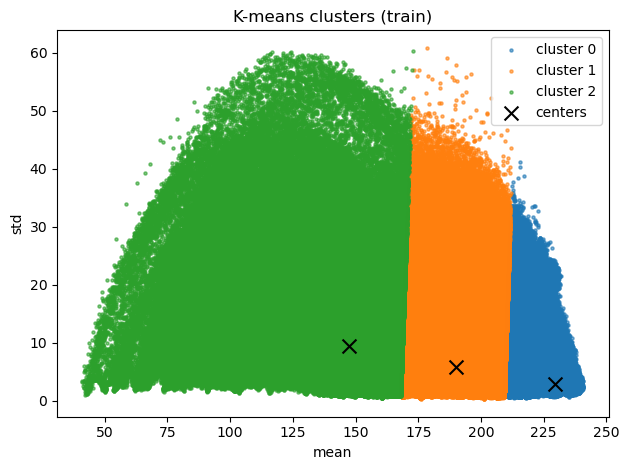

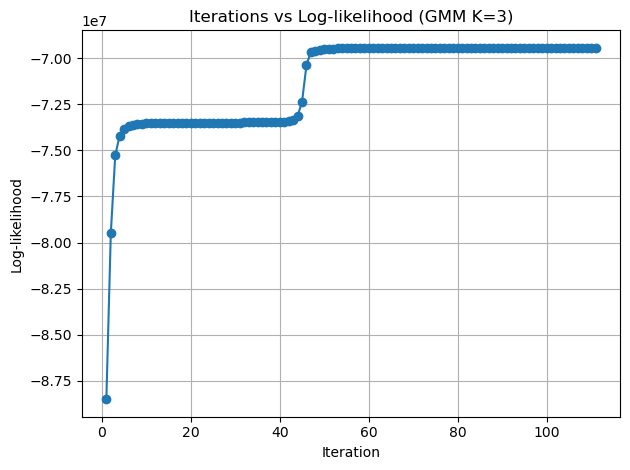

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

# ========= Utilities =========

def set_seed(seed=42):
    np.random.seed(seed)

def euclidean_sq(X, C):
    x2 = np.sum(X**2, axis=1, keepdims=True)
    c2 = np.sum(C**2, axis=1, keepdims=True).T
    return x2 + c2 - 2.0 * X @ C.T

# ========= K-means (from scratch) =========

def kmeans_plus_plus_init(X, K):
    N, D = X.shape
    centers = np.empty((K, D))
    idx0 = np.random.randint(0, N)
    centers[0] = X[idx0]
    d2 = euclidean_sq(X, centers[0:1]).ravel()
    for k in range(1, K):
        probs = d2 / d2.sum()
        idx = np.random.choice(N, p=probs)
        centers[k] = X[idx]
        d2 = np.minimum(d2, euclidean_sq(X, centers[k:k+1]).ravel())
    return centers

def kmeans(X, K=3, max_iter=200, tol=1e-6, n_init=3, seed=42):
    set_seed(seed)
    N, D = X.shape
    best_inertia = np.inf
    best_centers = None
    best_labels = None
    best_iters = 0

    for run in range(n_init):
        centers = kmeans_plus_plus_init(X, K)
        prev_inertia = np.inf
        for it in range(max_iter):
            d2 = euclidean_sq(X, centers)
            labels = np.argmin(d2, axis=1)
            inertia = np.sum(np.min(d2, axis=1))

            new_centers = np.zeros_like(centers)
            for k in range(K):
                pts = X[labels == k]
                if len(pts) == 0:
                    new_centers[k] = X[np.random.randint(0, N)]
                else:
                    new_centers[k] = pts.mean(axis=0)

            if abs(prev_inertia - inertia) <= tol:
                break
            centers = new_centers
            prev_inertia = inertia

        if inertia < best_inertia:
            best_inertia = inertia
            best_centers = centers
            best_labels = labels
            best_iters = it + 1

    return best_centers, best_labels, best_inertia, best_iters

# ========= GMM EM (from scratch) =========

def log_gaussian_pdf(X, mean, cov):
    D = X.shape[1]
    U, S, Vt = np.linalg.svd(cov)
    S_inv = np.diag(1.0 / (S + 1e-12))
    cov_inv = (Vt.T) @ S_inv @ U.T
    sign, logdet = np.linalg.slogdet(cov + 1e-12*np.eye(D))
    xc = X - mean
    quad = np.sum((xc @ cov_inv) * xc, axis=1)
    return -0.5 * (D * np.log(2.0 * np.pi) + logdet + quad)

def gmm_em(X, K=3, max_iter=300, tol=1e-5, init_means=None, seed=42):
    set_seed(seed)
    N, D = X.shape

    if init_means is None:
        init_means, init_labels, _, _ = kmeans(X, K=K, max_iter=100, tol=1e-5, n_init=1, seed=seed)
    else:
        init_labels = np.argmin(euclidean_sq(X, init_means), axis=1)

    means = init_means.copy()
    pis = np.zeros(K)
    covs = np.zeros((K, D, D))
    for k in range(K):
        pts = X[init_labels == k]
        Nk = max(len(pts), 1)
        pis[k] = Nk / N
        if len(pts) <= 1:
            covs[k] = np.cov(X.T) + 1e-6 * np.eye(D)
        else:
            covs[k] = np.cov(pts.T) + 1e-6 * np.eye(D)

    loglik_trace = []
    prev_ll = -np.inf

    for it in range(max_iter):
        # E-step
        log_resp_num = np.zeros((N, K))
        for k in range(K):
            log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf(X, means[k], covs[k])
        m = np.max(log_resp_num, axis=1, keepdims=True)
        log_sum = m + np.log(np.sum(np.exp(log_resp_num - m), axis=1, keepdims=True))
        log_resp = log_resp_num - log_sum
        resp = np.exp(log_resp)

        ll = float(np.sum(log_sum))
        loglik_trace.append(ll)
        if it > 0 and abs(ll - prev_ll) <= tol:
            break
        prev_ll = ll

        # M-step
        Nk = resp.sum(axis=0) + 1e-12
        pis = Nk / N
        means = (resp.T @ X) / Nk[:, None]
        for k in range(K):
            xc = X - means[k]
            covs[k] = (resp[:, [k]] * xc).T @ xc / Nk[k] + 1e-6 * np.eye(D)

    labels_pred = np.argmax(resp, axis=1)
    params = {"pi": pis, "means": means, "covs": covs}
    return params, np.array(loglik_trace), labels_pred

def gmm_predict_labels(X, params):
    pis = params["pi"]; means = params["means"]; covs = params["covs"]
    N = X.shape[0]; K = means.shape[0]
    log_resp_num = np.zeros((N, K))
    for k in range(K):
        log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf(X, means[k], covs[k])
    return np.argmax(log_resp_num, axis=1)

# ========= Metrics (from scratch) =========

def confusion_matrix_from_labels(y_true, y_pred, K):
    C = np.zeros((K, K), dtype=int)
    for t, p in zip(y_true, y_pred):
        C[t, p] += 1
    return C

def precision_recall_f1_from_confusion(C):
    K = C.shape[0]
    TP = np.diag(C).astype(float)
    FP = C.sum(axis=0) - TP
    FN = C.sum(axis=1) - TP
    precision = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
    recall    = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
    f1 = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(TP), where=(precision+recall)!=0)
    return precision, recall, f1

def accuracy_from_confusion(C):
    return np.sum(np.diag(C)) / max(1, np.sum(C))

# ========= Label alignment (brute-force for K small) =========

def best_label_mapping(y_pred, y_true, K):
    best_map = tuple(range(K))
    best_acc = -1.0
    for perm in itertools.permutations(range(K)):
        mp = {i: perm[i] for i in range(K)}
        yp = np.array([mp[c] for c in y_pred])
        acc = np.mean(yp == y_true)
        if acc > best_acc:
            best_acc = acc
            best_map = perm
    return {i: best_map[i] for i in range(K)}, best_acc

def apply_mapping(labels, mapping):
    return np.array([mapping[c] for c in labels])

# ========= Patch-to-pixel projection (majority vote) =========

def segmentation_mask_from_patch_labels(img_h, img_w, patch_size=7, stride=1, labels=None):
    H, W = img_h, img_w
    ph = pw = patch_size
    sh = sw = stride
    nh = (H - ph) // sh + 1
    nw = (W - pw) // sw + 1
    assert labels.shape[0] == nh*nw, "Labels count must match number of patches"
    K = int(np.max(labels)) + 1
    votes = np.zeros((H, W, K), dtype=int)
    idx = 0
    for i in range(nh):
        for j in range(nw):
            lab = int(labels[idx])
            r0 = i*sh; c0 = j*sw
            votes[r0:r0+ph, c0:c0+pw, lab] += 1
            idx += 1
    mask = np.argmax(votes, axis=2)
    return mask

# ========= Visualization =========

def plot_training_clusters_2d(X, labels, centers=None, title="Training clusters (2D)"):
    plt.figure()
    Kp = int(np.max(labels)) + 1
    for k in range(Kp):
        pts = X[labels == k]
        plt.scatter(pts[:,0], pts[:,1], s=5, alpha=0.6, label=f"cluster {k}")
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='k', marker='x', s=100, label="centers")
    plt.xlabel("mean")
    plt.ylabel("std")
    plt.legend()
    plt.title(title)
    plt.tight_layout()

def show_segmentation(mask, title="Segmentation"):
    plt.figure()
    plt.imshow(mask, cmap='tab10', interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

def plot_loglik_iterations(loglik_trace, label="GMM"):
    plt.figure()
    plt.plot(np.arange(1, len(loglik_trace)+1), loglik_trace, marker='o', linewidth=1.5)
    plt.xlabel("Iteration")
    plt.ylabel("Log-likelihood")
    plt.title(f"Iterations vs Log-likelihood ({label})")
    plt.grid(True)
    plt.tight_layout()

# ========= Diagonal-covariance GMM EM (fast) =========

def log_gaussian_pdf_diag(X, mean, var):
    """
    X: (N,D), mean: (D,), var: (D,) strictly positive variances
    Returns log N(x|mean, diag(var)) per row.
    """
    D = X.shape[1]
    # avoid division by zero
    var = np.maximum(var, 1e-12)
    xc = X - mean
    # elementwise quadratic form with diagonal inverse
    quad = np.sum((xc * xc) / var, axis=1)
    logdet = np.sum(np.log(var))
    return -0.5 * (D * np.log(2.0 * np.pi) + logdet + quad)

def gmm_em_diag(X, K=3, max_iter=300, tol=1e-5, init_means=None, seed=42, print_every=5):
    """
    EM for GMM with diagonal covariances.
    Params returned:
      - pi: (K,)
      - means: (K,D)
      - vars: (K,D)  # per-dimension variances
    """
    np.random.seed(seed)
    N, D = X.shape
    print(f"[GMM-diag] EM fit on {N} samples, D={D}, K={K}")

    # Initialize via K-means means if none provided
    if init_means is None:
        print("[GMM-diag] Initializing means via K-means ...")
        km_means, km_labels, _, _ = kmeans(X, K=K, max_iter=100, tol=1e-5, n_init=1, seed=seed)
        means = km_means
        labels0 = km_labels
    else:
        means = init_means.copy()
        labels0 = np.argmin(euclidean_sq(X, means), axis=1)

    # Initialize mixing weights and diagonal variances
    pis = np.zeros(K)
    vars_diag = np.zeros((K, D))
    global_var = np.var(X, axis=0) + 1e-6
    for k in range(K):
        pts = X[labels0 == k]
        Nk = len(pts)
        pis[k] = max(Nk, 1) / N
        if Nk <= 1:
            vars_diag[k] = global_var
        else:
            diff = pts - pts.mean(axis=0)
            vars_diag[k] = np.mean(diff * diff, axis=0) + 1e-6
    print(f"[GMM-diag] Init pis: {np.round(pis, 4)}")

    loglik_trace = []
    prev_ll = -np.inf

    for it in range(max_iter):
        # E-step: responsibilities in log-space
        log_resp_num = np.zeros((N, K))
        for k in range(K):
            log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf_diag(X, means[k], vars_diag[k])
        m = np.max(log_resp_num, axis=1, keepdims=True)
        log_sum = m + np.log(np.sum(np.exp(log_resp_num - m), axis=1, keepdims=True))
        log_resp = log_resp_num - log_sum
        resp = np.exp(log_resp)

        ll = float(np.sum(log_sum))
        loglik_trace.append(ll)
        if it % print_every == 0:
            print(f"[GMM-diag] iter {it:3d} loglik={ll:.6f}")

        if it > 0 and abs(ll - prev_ll) <= tol:
            print(f"[GMM-diag] converged at iter {it} (Δll={ll-prev_ll:.6e})")
            break
        prev_ll = ll

        # M-step: update pis, means, diagonal variances
        Nk = resp.sum(axis=0) + 1e-12            # (K,)
        pis = Nk / N                              # (K,)
        means = (resp.T @ X) / Nk[:, None]       # (K,D)

        # diagonal variances: weighted average of squared residuals per dim
        for k in range(K):
            xc = X - means[k]                    # (N,D)
            # weighted variance per dimension
            vars_k = (resp[:, k][:, None] * (xc * xc)).sum(axis=0) / Nk[k]
            vars_diag[k] = np.maximum(vars_k, 1e-6)

    print(f"[GMM-diag] Done. final loglik={loglik_trace[-1]:.6f}, iters={len(loglik_trace)}")
    labels_pred = np.argmax(resp, axis=1)
    params = {"pi": pis, "means": means, "vars": vars_diag}
    return params, np.array(loglik_trace), labels_pred

def gmm_predict_labels_diag(X, params):
    pis = params["pi"]; means = params["means"]; vars_diag = params["vars"]
    N = X.shape[0]; K = means.shape[0]
    log_resp_num = np.zeros((N, K))
    for k in range(K):
        log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf_diag(X, means[k], vars_diag[k])
    return np.argmax(log_resp_num, axis=1)




# ========= End-to-end using your loaders =========

def fit_and_evaluate_with_loaders(X_train, train_files, test_items, K=3, seed=7):
    set_seed(seed)

    # 1) K-means on all training features
    km_centers, km_labels_train, km_inertia, km_iters = kmeans(X_train, K=K, n_init=5, max_iter=300, tol=1e-6, seed=seed)
    plot_training_clusters_2d(X_train, km_labels_train, centers=km_centers, title="K-means clusters (train)")

    # If you have training ground-truth labels per patch, load them to compute train metrics.
    # Otherwise, skip alignment on train and do it on a validation set or heuristics.
    # Here we try to auto-detect optional parallel label files: replace suffix or folder if available.
    y_train = None
    # Example: suppose a parallel folder "train_labels" mirrors train_files by filename.
    label_candidates = []
    for f in train_files:
        base = os.path.basename(f)
        # Adapt this mapping to your file naming if needed:
        label_path = f.replace("train_processed", "train_labels")
        label_path = label_path.replace(".npy", "_labels.npy")
        if os.path.exists(label_path):
            label_candidates.append(label_path)
        else:
            label_candidates = []
            break
    if label_candidates:
        y_list = []
        for p in label_candidates:
            arr = np.load(p, allow_pickle=True)
            if arr.dtype == object:
                y = arr.item().get("labels", None)
                if y is None:
                    y = arr.item().get("gt", None)
                if y is None:
                    raise ValueError(f"No 'labels' in {p}")
            else:
                y = arr
            if y.ndim > 1:
                y = y.reshape(-1)
            y_list.append(y.astype(int))
        y_train = np.concatenate(y_list, axis=0)

    # 2) GMM initialized from K-means
    # gmm_params, gmm_trace, gmm_labels_train = gmm_em(X_train, K=K, max_iter=300, tol=1e-5, init_means=km_centers, seed=seed)
    gmm_params, gmm_trace, gmm_labels_train = gmm_em_diag(
        X_train, K=3, max_iter=300, tol=1e-5, init_means=km_centers, seed=7, print_every=5
        )
    plot_loglik_iterations(gmm_trace, label=f"GMM K={K}")

    # 3) Metrics on training (if y_train available)
    metrics = {}
    if y_train is not None and y_train.shape[0] == X_train.shape[0]:
        km_map, _ = best_label_mapping(km_labels_train, y_train, K)
        gmm_map, _ = best_label_mapping(gmm_labels_train, y_train, K)

        km_aligned = apply_mapping(km_labels_train, km_map)
        gmm_aligned = apply_mapping(gmm_labels_train, gmm_map)

        C_km = confusion_matrix_from_labels(y_train, km_aligned, K)
        C_gm = confusion_matrix_from_labels(y_train, gmm_aligned, K)

        p_km, r_km, f_km = precision_recall_f1_from_confusion(C_km)
        p_gm, r_gm, f_gm = precision_recall_f1_from_confusion(C_gm)

        metrics["train"] = {
            "kmeans": {
                "accuracy": accuracy_from_confusion(C_km),
                "precision_per_class": p_km, "recall_per_class": r_km, "f1_per_class": f_km,
                "macro_precision": p_km.mean(), "macro_recall": r_km.mean(), "macro_f1": f_km.mean(),
                "confusion": C_km
            },
            "gmm": {
                "accuracy": accuracy_from_confusion(C_gm),
                "precision_per_class": p_gm, "recall_per_class": r_gm, "f1_per_class": f_gm,
                "macro_precision": p_gm.mean(), "macro_recall": r_gm.mean(), "macro_f1": f_gm.mean(),
                "confusion": C_gm
            }
        }
    else:
        # If no GT, create identity mappings for later; you can supply a validation set for alignment.
        km_map = {i: i for i in range(K)}
        gmm_map = {i: i for i in range(K)}

    # 4) Inference on test items + optional metrics if test labels exist
    all_preds_gmm = []
    all_truth = []

    for item in test_items:
        F = item["features"]              # (num_patches, 2)
        H, W = item["image_shape"]        # if provided
        patch_size = item["patch_size"]
        stride = item["stride"]

        # Predict cluster ids by GMM likelihood
        pred_raw = gmm_predict_labels_diag(F, gmm_params)
        pred = apply_mapping(pred_raw, gmm_map)

        # Collect metrics if per-patch labels provided in same npy (object) file
        # Expect optional keys: "labels" or "gt"
        arr = np.load(item["path"], allow_pickle=True)
        y_te = None
        if arr.dtype == object:
            d = arr.item()
            if "labels" in d:
                y_te = np.array(d["labels"]).astype(int).reshape(-1)
            elif "gt" in d:
                y_te = np.array(d["gt"]).astype(int).reshape(-1)

        if y_te is not None and y_te.shape[0] == F.shape[0]:
            all_preds_gmm.append(pred)
            all_truth.append(y_te)

        # Visualization: segmentation mask if H,W present and >0
        if H > 0 and W > 0:
            try:
                mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=pred)
                show_segmentation(mask, title=os.path.basename(item["path"]) + " - GMM segmentation")
            except AssertionError:
                pass  # skip if dimensions/patch counts mismatch

    # Test metrics aggregation
    if len(all_truth) > 0:
        y_true = np.concatenate(all_truth, axis=0)
        y_pred = np.concatenate(all_preds_gmm, axis=0)
        C_test = confusion_matrix_from_labels(y_true, y_pred, K)
        p, r, f = precision_recall_f1_from_confusion(C_test)
        metrics["test_gmm"] = {
            "accuracy": accuracy_from_confusion(C_test),
            "precision_per_class": p, "recall_per_class": r, "f1_per_class": f,
            "macro_precision": p.mean(), "macro_recall": r.mean(), "macro_f1": f.mean(),
            "confusion": C_test
        }

    return {
        "kmeans": {"centers": km_centers, "labels_train": km_labels_train, "inertia": km_inertia, "iters": km_iters},
        "gmm": {"params": gmm_params, "trace": gmm_trace, "labels_train": gmm_labels_train},
        "maps": {"kmeans": km_map, "gmm": gmm_map},
        "metrics": metrics
    }

def kmeans_plus_plus_init(X, K):
    print(f"[KMeans] k-means++ init for K={K} ...")
    N, D = X.shape
    centers = np.empty((K, D))
    # pick first center uniformly
    idx0 = np.random.randint(0, N)
    centers[0] = X[idx0]
    # initial distances^2 to the first center
    d2 = euclidean_sq(X, centers[0:1]).ravel()
    # numerical guard
    d2 = np.maximum(d2, 0.0)
    for k in range(1, K):
        s = d2.sum()
        if not np.isfinite(s) or s <= 0:
            # fallback: uniform pick to avoid invalid probabilities
            idx = np.random.randint(0, N)
        else:
            probs = d2 / (s + 1e-18)
            # clip for safety and renormalize
            probs = np.clip(probs, 0.0, 1.0)
            ps = probs.sum()
            if ps <= 0 or not np.isfinite(ps):
                idx = np.random.randint(0, N)
            else:
                probs = probs / ps
                idx = np.random.choice(N, p=probs)
        centers[k] = X[idx]
        # update min distance^2 to any chosen center so far
        dk = euclidean_sq(X, centers[k:k+1]).ravel()
        dk = np.maximum(dk, 0.0)
        d2 = np.minimum(d2, dk)
    print("[KMeans] init centers ready.")
    return centers

def kmeans(X, K=3, max_iter=200, tol=1e-6, n_init=3, seed=42):
    set_seed(seed)
    N, D = X.shape
    if N == 0:
        raise ValueError("Empty training set: X has zero rows.")
    if D == 0:
        raise ValueError("Feature dimension is zero.")
    print(f"[KMeans] Fitting on {N} samples, dim={D}, K={K}, n_init={n_init}")
    best_inertia = np.inf
    best_centers = None
    best_labels = None
    best_iters = 0

    for run in range(n_init):
        print(f"[KMeans] Run {run+1}/{n_init}")
        centers = kmeans_plus_plus_init(X, K)
        prev_inertia = np.inf
        for it in range(max_iter):
            d2 = euclidean_sq(X, centers)
            # guard against tiny negative numerical artifacts
            d2 = np.maximum(d2, 0.0)
            labels = np.argmin(d2, axis=1)
            min_d2 = np.min(d2, axis=1)
            inertia = float(np.sum(min_d2))

            # update step with empty-cluster handling
            new_centers = np.zeros_like(centers)
            for k in range(K):
                pts = X[labels == k]
                if len(pts) == 0:
                    # reseed with a random point
                    new_centers[k] = X[np.random.randint(0, N)]
                else:
                    new_centers[k] = pts.mean(axis=0)

            if it % 10 == 0:
                print(f"[KMeans] iter {it:3d} inertia={inertia:.6f}")

            if abs(prev_inertia - inertia) <= tol:
                print(f"[KMeans] converged at iter {it} with inertia={inertia:.6f}")
                break
            centers = new_centers
            prev_inertia = inertia

        if inertia < best_inertia:
            best_inertia = inertia
            best_centers = centers
            best_labels = labels
            best_iters = it + 1

    print(f"[KMeans] Best inertia={best_inertia:.6f}, iters={best_iters}")
    return best_centers, best_labels, best_inertia, best_iters

# ========= Run with your loaded data =========
import os
import numpy as np
from glob import glob

def load_train_features(train_processed_dir):
    # Stack all train features for unsupervised fitting
    X_list = []
    files = sorted(glob(os.path.join(train_processed_dir, "*.npy")))
    for f in files:
        arr = np.load(f, allow_pickle=True)
        if arr.dtype == object:
            d = arr.item()
            F = d["features"]       # (num_patches, 2)
        else:
            F = arr                 # if you saved raw arrays
        if F.ndim == 1:
            F = F.reshape(1, -1)
        X_list.append(F)
    X_train = np.vstack(X_list) if X_list else np.empty((0,2))
    return X_train, files

def load_test_items(test_processed_dir):
    # Keep per-image features and shapes to generate per-image segmentations
    items = []
    files = sorted(glob(os.path.join(test_processed_dir, "*.npy")))
    for f in files:
        arr = np.load(f, allow_pickle=True)
        if arr.dtype == object:
            d = arr.item()
            F = d["features"]
            H, W = map(int, d.get("image_shape", (0,0)))
            patch_size = int(d.get("patch_size", 7))
            stride = int(d.get("stride", 1))
        else:
            F = arr
            H, W, patch_size, stride = 0, 0, 7, 1  # fallback
        if F.ndim == 1:
            F = F.reshape(1, -1)
        items.append({"path": f, "features": F, "image_shape": (H, W),
                      "patch_size": patch_size, "stride": stride})
    return items


X_train, train_files = load_train_features(r"../Dataset/Group04-cervical_cytology_images/group04/Train/processed/")
test_items = load_test_items(r"../Dataset/Group04-cervical_cytology_images/group04/Test/processed/")
print("X_train:", X_train.shape, "| #train files:", len(train_files))
print("#test files:", len(test_items))
# Example call (you already have X_train, train_files, test_items)
results = fit_and_evaluate_with_loaders(X_train, train_files, test_items, K=3, seed=7)

# Print summary metrics if available
if "train" in results["metrics"]:
    print("\nTrain (K-means) accuracy:", results["metrics"]["train"]["kmeans"]["accuracy"])
    print("Train (GMM) accuracy:", results["metrics"]["train"]["gmm"]["accuracy"])

if "test_gmm" in results["metrics"]:
    m = results["metrics"]["test_gmm"]
    print("\n=== Test (GMM) ===")
    print("Accuracy:", m["accuracy"])
    for c in range(3):
        print(f"Class {c}: Precision={m['precision_per_class'][c]:.4f} "
              f"Recall={m['recall_per_class'][c]:.4f} F1={m['f1_per_class'][c]:.4f}")
    print("Macro Precision/Recall/F1:",
          m["macro_precision"], m["macro_recall"], m["macro_f1"])
    print("\nConfusion matrix (rows=true, cols=pred):\n", m["confusion"])

plt.show()


In [8]:
import numpy as np
import os

def save_segmenter_npz(save_path, K, seed, kmeans_centers, gmm_params, maps, meta=None):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Flatten mappings into arrays for portability
    map_km = np.array([maps["kmeans"].get(i, i) for i in range(K)], dtype=int)
    map_gm = np.array([maps["gmm"].get(i, i) for i in range(K)], dtype=int)

    # Choose keys depending on your GMM type (diag here)
    np.savez(
        save_path,
        K=np.array([K], dtype=int),
        seed=np.array([seed], dtype=int),
        kmeans_centers=kmeans_centers.astype(np.float64),
        gmm_pi=gmm_params["pi"].astype(np.float64),
        gmm_means=gmm_params["means"].astype(np.float64),
        gmm_vars=gmm_params["vars"].astype(np.float64),   # diagonal variances
        map_kmeans=map_km,
        map_gmm=map_gm,
        meta=meta if meta is not None else {}
    )
    print(f"[Save] Model saved to {save_path}")
def load_segmenter_npz(load_path):
    d = np.load(load_path, allow_pickle=True)
    K = int(d["K"][0])
    seed = int(d["seed"][0])
    kmeans_centers = d["kmeans_centers"]
    gmm_params = {
        "pi": d["gmm_pi"],
        "means": d["gmm_means"],
        "vars": d["gmm_vars"],  # diagonal variances
    }
    maps = {
        "kmeans": {i:int(d["map_kmeans"][i]) for i in range(K)},
        "gmm": {i:int(d["map_gmm"][i]) for i in range(K)}
    }
    meta = d["meta"].item() if "meta" in d.files else {}
    print(f"[Load] Model loaded from {load_path} (K={K})")
    return K, seed, kmeans_centers, gmm_params, maps, meta


In [12]:
# After training in your driver+
# After calling:
# results = fit_and_evaluate_with_loaders(X_train, train_files, test_items, K=3, seed=7)

km_centers = results["kmeans"]["centers"]
gmm_params = results["gmm"]["params"]          # For diagonal GMM: keys "pi","means","vars"
km_map = results["maps"]["kmeans"]
gmm_map = results["maps"]["gmm"]

meta = {"feature_dim": X_train.shape[1], "covariance_type": "diag", "note": "Dataset 2(c)"}
save_segmenter_npz(
    "models/cell_segmenter_diag.npz",
    K=3, seed=7,
    kmeans_centers=km_centers,
    gmm_params=gmm_params,
    maps={"kmeans": km_map, "gmm": gmm_map},
    meta=meta
)


[Save] Model saved to models/cell_segmenter_diag.npz


In [13]:
# Use your existing loader
# test_items = load_test_items(test_processed_dir)

# Load model
K, seed, kmeans_centers, gmm_params, maps, meta = load_segmenter_npz("models/cell_segmenter_diag.npz")

# Predict per test image, reconstruct segmentation, and (optionally) compute metrics if labels present
all_preds = []
all_truth = []
for idx, item in enumerate(test_items):
    F = item["features"]                     # (num_patches, 2)
    H, W = item["image_shape"]
    patch_size = item["patch_size"]
    stride = item["stride"]

    # Predict cluster ids with diagonal GMM
    pred_raw = gmm_predict_labels_diag(F, gmm_params)
    pred = apply_mapping(pred_raw, maps["gmm"])
    all_preds.append(pred)

    # Optional metrics if labels present in the file object
    arr = np.load(item["path"], allow_pickle=True)
    if arr.dtype == object:
        d = arr.item()
        y_te = d.get("labels", d.get("gt", None))
        if y_te is not None and len(y_te) == F.shape[0]:
            all_truth.append(np.asarray(y_te, dtype=int))

    # Optional segmentation visualization
    if H > 0 and W > 0:
        try:
            mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=pred)
            show_segmentation(mask, title=os.path.basename(item["path"]) + " - GMM segmentation")
        except AssertionError as e:
            print(f"[Infer] Skip mask: {e}")

# Aggregate test metrics if GT was available
if len(all_truth) > 0:
    y_true = np.concatenate(all_truth, 0)
    y_pred = np.concatenate(all_preds, 0)
    C = confusion_matrix_from_labels(y_true, y_pred, K)
    p, r, f = precision_recall_f1_from_confusion(C)
    print(f"[Test] acc={accuracy_from_confusion(C):.4f}, macro P/R/F1=({p.mean():.4f}/{r.mean():.4f}/{f.mean():.4f})")
    print("[Test] Confusion (rows=true, cols=pred):\n", C)


[Load] Model loaded from models/cell_segmenter_diag.npz (K=3)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- load saved model ---

def load_segmenter_npz(load_path):
    d = np.load(load_path, allow_pickle=True)
    K = int(d["K"][0])
    seed = int(d["seed"][0])
    kmeans_centers = d["kmeans_centers"]
    gmm_params = {"pi": d["gmm_pi"], "means": d["gmm_means"], "vars": d["gmm_vars"]}
    maps = {
        "kmeans": {i:int(d["map_kmeans"][i]) for i in range(K)},
        "gmm": {i:int(d["map_gmm"][i]) for i in range(K)}
    }
    meta = d["meta"].item() if "meta" in d.files else {}
    return K, seed, kmeans_centers, gmm_params, maps, meta
# [web:66]

# --- diagonal GMM predict ---

def log_gaussian_pdf_diag(X, mean, var):
    var = np.maximum(var, 1e-12)
    xc = X - mean
    quad = np.sum((xc * xc) / var, axis=1)
    logdet = np.sum(np.log(var))
    D = X.shape[1]
    return -0.5 * (D * np.log(2.0 * np.pi) + logdet + quad)
# [web:61]

def gmm_predict_labels_diag(X, params):
    pis = params["pi"]; means = params["means"]; vars_diag = params["vars"]
    N = X.shape[0]; K = means.shape[0]
    log_resp_num = np.zeros((N, K))
    for k in range(K):
        log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf_diag(X, means[k], vars_diag[k])
    return np.argmax(log_resp_num, axis=1)
# [web:61]

def apply_mapping(labels, mapping):
    return np.array([mapping[int(c)] for c in labels], dtype=int)
# [web:61]

# --- feature extraction from .npy image ---

def extract_patch_features_mean_std_from_array(img, patch_size=7, stride=1):
    if img.ndim == 3:
        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        img = img.astype(np.float32)
    else:
        img = img.astype(np.float32)
    H, W = img.shape
    ph = pw = patch_size
    sh = sw = stride
    nh = (H - ph) // sh + 1
    nw = (W - pw) // sw + 1
    feats = np.empty((nh * nw, 2), dtype=np.float32)
    idx = 0
    for i in range(nh):
        r0 = i * sh
        for j in range(nw):
            c0 = j * sw
            patch = img[r0:r0+ph, c0:c0+pw]
            feats[idx, 0] = patch.mean()
            feats[idx, 1] = patch.std(ddof=0)
            idx += 1
    return feats, (H, W), nh, nw
# [web:95]

# --- patch-to-pixel majority vote ---

def segmentation_mask_from_patch_labels(img_h, img_w, patch_size=7, stride=1, labels=None):
    H, W = img_h, img_w
    ph = pw = patch_size
    sh = sw = stride
    nh = (H - ph) // sh + 1
    nw = (W - pw) // sw + 1
    assert labels.shape[0] == nh * nw, "Labels count must match number of patches"
    K = int(np.max(labels)) + 1
    votes = np.zeros((H, W, K), dtype=int)
    idx = 0
    for i in range(nh):
        for j in range(nw):
            lab = int(labels[idx])
            r0 = i * sh; c0 = j * sw
            votes[r0:r0+ph, c0:c0+pw, lab] += 1
            idx += 1
    mask = np.argmax(votes, axis=2)
    return mask
# [web:85]

# --- segment a .npy image array ---

def segment_npy_image(npy_image_path, model_npz_path, patch_size=7, stride=1, show=True):
    # Load image array
    arr = np.load(npy_image_path, allow_pickle=True)
    if arr.dtype == object:
        d = arr.item()
        img = d.get("image", None)
        if img is None:
            # if only features saved, you can directly predict without reconstruction
            F = d["features"]
            H, W = map(int, d.get("image_shape", (0,0)))
        else:
            img = np.array(img)
            F = None
            H, W = img.shape[:2]
        ps = int(d.get("patch_size", patch_size))
        st = int(d.get("stride", stride))
        patch_size, stride = ps, st
    else:
        img = arr
        F = None
        H, W = img.shape[:2]
    # [web:66]

    # Load model
    K, seed, km_centers, gmm_params, maps, meta = load_segmenter_npz(model_npz_path)
    if meta.get("covariance_type", "diag") != "diag":
        raise ValueError("This loader expects a diagonal-covariance GMM model.")
    # [web:61]

    # Build features if not present
    if F is None:
        F, (H, W), nh, nw = extract_patch_features_mean_std_from_array(img, patch_size=patch_size, stride=stride)
    else:
        nh = (H - patch_size) // stride + 1 if H and W else None
        nw = (W - patch_size) // stride + 1 if H and W else None
    # [web:95]

    # Predict clusters and map to classes
    raw = gmm_predict_labels_diag(F, gmm_params)
    pred = apply_mapping(raw, maps["gmm"])
    # [web:61]

    # If H,W known, reconstruct pixel mask; else return patch labels
    if H and W and H > 0 and W > 0:
        mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=pred)
        if show:
            plt.figure(figsize=(10,4))
            if 'img' in locals() and img is not None and img.size > 0:
                plt.subplot(1,2,1); plt.imshow(img if img.ndim==2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray'); plt.title("Input"); plt.axis('off')
            else:
                plt.subplot(1,2,1); plt.imshow(np.zeros((H,W)), cmap='gray'); plt.title("Input (not in npy)"); plt.axis('off')
            plt.subplot(1,2,2); plt.imshow(mask, cmap='tab10', interpolation='nearest'); plt.title("Segmentation"); plt.axis('off')
            plt.tight_layout(); plt.show()
        return mask
    else:
        # Return patch-level predictions if image shape is not available
        return pred
    # [web:85]


In [20]:
mask_or_patch_labels = segment_npy_image(
    npy_image_path=r"../Dataset/Group04-cervical_cytology_images/group04/Train/processed/34.npy",
    model_npz_path="models/cell_segmenter_diag.npz",
    patch_size=7,   # must match training
    stride=1,       # must match training
    show=True
)


ValueError: negative dimensions are not allowed

In [23]:
npy_image_path=r"../Dataset/Group04-cervical_cytology_images/group04/Train/processed/34.npy"
arr = np.load(npy_image_path, allow_pickle=True)
if arr.dtype == object:
    d = arr.item()
    F = d["features"]      # shape (num_patches, D), D must match training (e.g., 2)
    H, W = map(int, d.get("image_shape", (0,0)))
    patch_size = int(d.get("patch_size", 7))
    stride = int(d.get("stride", 1))
    # predict clusters then map to classes
    raw = gmm_predict_labels_diag(F, gmm_params)
    pred = apply_mapping(raw, maps["gmm"])
    if H > 0 and W > 0:
        mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=pred)
        # visualize/use mask
    else:
        print("else")
        # no shape provided—return per-patch labels
        pass
else:
    print("else")
    # raw image path—use guarded extractor above
    pass


else


In [24]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# --- Load model ---

def load_segmenter_npz(load_path):
    d = np.load(load_path, allow_pickle=True)
    K = int(d["K"][0])
    seed = int(d["seed"][0])
    kmeans_centers = d["kmeans_centers"]
    gmm_params = {"pi": d["gmm_pi"], "means": d["gmm_means"], "vars": d["gmm_vars"]}
    maps = {
        "kmeans": {i:int(d["map_kmeans"][i]) for i in range(K)},
        "gmm": {i:int(d["map_gmm"][i]) for i in range(K)}
    }
    meta = d["meta"].item() if "meta" in d.files else {}
    return K, seed, kmeans_centers, gmm_params, maps, meta

# --- Diagonal GMM predict ---

def log_gaussian_pdf_diag(X, mean, var):
    D = X.shape[1]
    var = np.maximum(var, 1e-12)
    xc = X - mean
    quad = np.sum((xc * xc) / var, axis=1)
    logdet = np.sum(np.log(var))
    return -0.5 * (D * np.log(2.0 * np.pi) + logdet + quad)

def gmm_predict_labels_diag(X, params):
    pis = params["pi"]; means = params["means"]; vars_diag = params["vars"]
    N = X.shape[0]; K = means.shape[0]
    log_resp_num = np.zeros((N, K))
    for k in range(K):
        log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf_diag(X, means[k], vars_diag[k])
    return np.argmax(log_resp_num, axis=1)

def apply_mapping(labels, mapping):
    return np.array([mapping[int(c)] for c in labels], dtype=int)

# --- Patch feature extraction (mean, std) ---

def extract_patch_features_mean_std(img, patch_size=7, stride=1):
    """
    img: 2D grayscale uint8/float image
    returns F: (num_patches, 2) in row-major sliding-window order
    """
    if img.ndim == 3:
        # convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)
    H, W = img.shape
    ph = pw = patch_size
    sh = sw = stride
    nh = (H - ph) // sh + 1
    nw = (W - pw) // sw + 1
    feats = np.empty((nh * nw, 2), dtype=np.float32)
    idx = 0
    for i in range(nh):
        r0 = i * sh
        for j in range(nw):
            c0 = j * sw
            patch = img[r0:r0+ph, c0:c0+pw]
            m = patch.mean()
            s = patch.std(ddof=0)
            feats[idx, 0] = m
            feats[idx, 1] = s
            idx += 1
    return feats, (H, W), nh, nw

# --- Patch-to-pixel majority vote ---

def segmentation_mask_from_patch_labels(img_h, img_w, patch_size=7, stride=1, labels=None):
    H, W = img_h, img_w
    ph = pw = patch_size
    sh = sw = stride
    nh = (H - ph) // sh + 1
    nw = (W - pw) // sw + 1
    assert labels.shape[0] == nh * nw, "Labels count must match number of patches"
    K = int(np.max(labels)) + 1
    votes = np.zeros((H, W, K), dtype=int)
    idx = 0
    for i in range(nh):
        for j in range(nw):
            lab = int(labels[idx])
            r0 = i * sh; c0 = j * sw
            votes[r0:r0+ph, c0:c0+pw, lab] += 1
            idx += 1
    mask = np.argmax(votes, axis=2)
    return mask

# --- One-shot API: segment an image path ---

def segment_image_with_saved_model(image_path, model_npz_path, patch_size=7, stride=1, show=True):
    # Load model
    K, seed, km_centers, gmm_params, maps, meta = load_segmenter_npz(model_npz_path)
    cov_type = meta.get("covariance_type", "diag")

    # Read image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(image_path)

    # Extract features in SAME way as training
    F, (H, W), nh, nw = extract_patch_features_mean_std(img, patch_size=patch_size, stride=stride)

    # Predict with diagonal GMM and map cluster->class
    if cov_type != "diag":
        raise ValueError(f"Expected diag covariance model, got {cov_type}")
    raw = gmm_predict_labels_diag(F, gmm_params)
    pred = apply_mapping(raw, maps["gmm"])

    # Reconstruct per-pixel mask by majority vote
    mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=pred)

    if show:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Input"); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(mask, cmap='tab10', interpolation='nearest'); plt.title("Segmentation"); plt.axis('off')
        plt.tight_layout(); plt.show()

    return mask


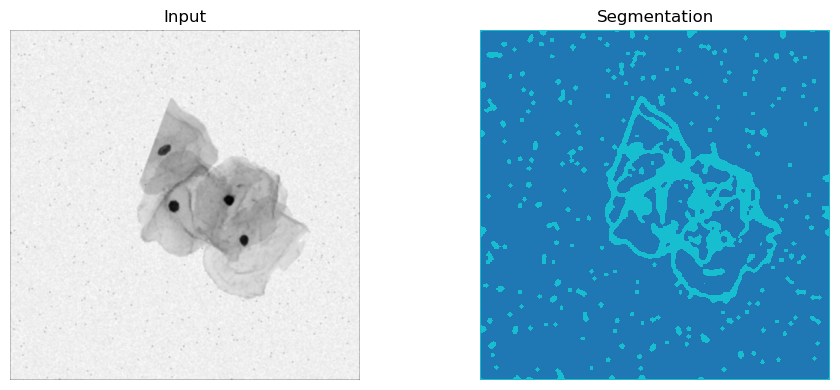

In [46]:
mask = segment_image_with_saved_model(
    image_path=r"../Dataset/Group04-cervical_cytology_images/group04/Test/14.png",
    model_npz_path="models/cell_segmenter_diag.npz",
    patch_size=7,   # must match training
    stride=1        # must match training
)


In [30]:
import numpy as np

# Assume you have these helpers and saved artifacts already:
# - euclidean_sq(X, C)
# - gmm_predict_labels_diag(F, gmm_params)
# - apply_mapping(labels, mapping)
# - segmentation_mask_from_patch_labels(H, W, patch_size, stride, labels)
# - load_segmenter_npz(path) -> (K, seed, km_centers, gmm_params, maps, meta)

def segment_test_npy_both(npy_path, model_npz_path, patch_size=7, stride=1, H=None, W=None):
    # Load model
    K, seed, km_centers, gmm_params, maps, meta = load_segmenter_npz(model_npz_path)
    assert K == 3, "K should be 3 for this task."
    # Load test features
    arr = np.load(npy_path, allow_pickle=True)
    if arr.dtype == object:
        d = arr.item()
        F = np.array(d["features"], dtype=np.float64)  # shape (num_patches, 2)
        H0, W0 = d.get("image_shape", (H, W))
        if H0 and W0:
            H, W = int(H0), int(W0)
        patch_size = int(d.get("patch_size", patch_size))
        stride = int(d.get("stride", stride))
    else:
        # If raw image array, you’d extract features; here we assume stacked features already
        raise ValueError("Expected object npy with 'features'.")
    # K-means prediction
    d2 = euclidean_sq(F, km_centers)
    km_raw = np.argmin(d2, axis=1)
    km_pred = apply_mapping(km_raw, maps["kmeans"])
    # GMM prediction (diagonal)
    gm_raw = gmm_predict_labels_diag(F, gmm_params)
    gm_pred = apply_mapping(gm_raw, maps["gmm"])
    # Optionally reconstruct pixel masks
    km_mask = None
    gm_mask = None
    if H and W and H > 0 and W > 0:
        km_mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=km_pred)
        gm_mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=gm_pred)
    return {"kmeans_patch_labels": km_pred, "gmm_patch_labels": gm_pred,
            "kmeans_mask": km_mask, "gmm_mask": gm_mask}


In [43]:
import numpy as np
from PIL import Image  # pip install pillow
import matplotlib.pyplot as plt
import os

# ---- Load model from NPZ (saved earlier) ----
def load_segmenter_npz(load_path):
    d = np.load(load_path, allow_pickle=True)
    K = int(d["K"][0])
    seed = int(d["seed"][0])
    kmeans_centers = d["kmeans_centers"]
    gmm_params = {"pi": d["gmm_pi"], "means": d["gmm_means"], "vars": d["gmm_vars"]}  # diag variances
    maps = {
        "kmeans": {i:int(d["map_kmeans"][i]) for i in range(K)},
        "gmm": {i:int(d["map_gmm"][i]) for i in range(K)}
    }
    meta = d["meta"].item() if "meta" in d.files else {}
    return K, seed, kmeans_centers, gmm_params, maps, meta  # [web:66]

# ---- K-means distance ----
def euclidean_sq(X, C):
    x2 = np.sum(X**2, axis=1, keepdims=True)
    c2 = np.sum(C**2, axis=1, keepdims=True).T
    return x2 + c2 - 2.0 * X @ C.T  # [web:72]

# ---- Diagonal GMM predict ----
def log_gaussian_pdf_diag(X, mean, var):
    var = np.maximum(var, 1e-12)
    xc = X - mean
    quad = np.sum((xc * xc) / var, axis=1)
    logdet = np.sum(np.log(var))
    D = X.shape[1]
    return -0.5 * (D * np.log(2.0 * np.pi) + logdet + quad)  # [web:61]

def gmm_predict_labels_diag(X, params):
    pis = params["pi"]; means = params["means"]; vars_diag = params["vars"]
    N = X.shape[0]; K = means.shape[0]
    log_resp_num = np.zeros((N, K))
    for k in range(K):
        log_resp_num[:, k] = np.log(pis[k] + 1e-12) + log_gaussian_pdf_diag(X, means[k], vars_diag[k])
    return np.argmax(log_resp_num, axis=1)  # [web:61]

def apply_mapping(labels, mapping):
    return np.array([mapping[int(c)] for c in labels], dtype=int)  # [web:61]

# ---- Grayscale + features from path ----
def load_image_gray_float(path):
    img = Image.open(path)
    img = img.convert("RGB")
    arr = np.asarray(img).astype(np.float32)
    # luminance grayscale
    gray = 0.299*arr[...,0] + 0.587*arr[...,1] + 0.114*arr[...,2]
    return gray  # [web:95]

def extract_patch_features_mean_std_from_array(img, patch_size=7, stride=1):
    img = np.asarray(img).astype(np.float32)
    if img.ndim != 2:
        raise ValueError("Expected grayscale 2D array.")
    H, W = img.shape
    if stride <= 0:
        raise ValueError("Stride must be positive.")
    if H < patch_size or W < patch_size:
        raise ValueError(f"Image too small for patch_size={patch_size}: got H={H}, W={W}.")
    nh = (H - patch_size) // stride + 1
    nw = (W - patch_size) // stride + 1
    feats = np.empty((nh * nw, 2), dtype=np.float32)
    idx = 0
    for i in range(nh):
        r0 = i * stride
        for j in range(nw):
            c0 = j * stride
            patch = img[r0:r0+patch_size, c0:c0+patch_size]
            feats[idx, 0] = patch.mean()
            feats[idx, 1] = patch.std(ddof=0)
            idx += 1
    return feats, (H, W), nh, nw  # [web:95]

# ---- Majority vote projection ----
def segmentation_mask_from_patch_labels(img_h, img_w, patch_size=7, stride=1, labels=None):
    H, W = img_h, img_w
    ph = pw = patch_size
    sh = sw = stride
    nh = (H - ph) // sh + 1
    nw = (W - pw) // sw + 1
    if labels.shape[0] != nh*nw:
        raise ValueError(f"Labels count {labels.shape[0]} != nh*nw {nh*nw}")
    K = int(np.max(labels)) + 1
    votes = np.zeros((H, W, K), dtype=int)
    idx = 0
    for i in range(nh):
        for j in range(nw):
            lab = int(labels[idx])
            r0 = i*sh; c0 = j*sw
            votes[r0:r0+ph, c0:c0+pw, lab] += 1
            idx += 1
    mask = np.argmax(votes, axis=2)
    return mask  # [web:85]

# ---- One-call function: segment with both K-means and GMM from a normal image path ----
def segment_image_both(image_path, model_npz_path, patch_size=7, stride=1, show=True):
    # Load model and metadata
    K, seed, km_centers, gmm_params, maps, meta = load_segmenter_npz(model_npz_path)
    cov_type = meta.get("covariance_type", "diag")
    if K != 3:
        raise ValueError("This task expects K=3.")
    if cov_type != "diag":
        raise ValueError("Use diagonal-covariance GMM parameters for this function.")
    # Load and feature-ize image
    gray = load_image_gray_float(image_path)
    F, (H, W), nh, nw = extract_patch_features_mean_std_from_array(gray, patch_size=patch_size, stride=stride)
    # K-means prediction
    d2 = euclidean_sq(F, km_centers)
    km_raw = np.argmin(np.maximum(d2, 0.0), axis=1)
    km_pred = apply_mapping(km_raw, maps["kmeans"])
    # GMM prediction
    gm_raw = gmm_predict_labels_diag(F, gmm_params)
    gm_pred = apply_mapping(gm_raw, maps["gmm"])
    # Reconstruct pixel masks
    km_mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=km_pred)
    gm_mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=gm_pred)
    # Show
    if show:
        plt.figure(figsize=(15,4))
        plt.subplot(1,3,1); plt.imshow(gray, cmap='gray'); plt.title("Input"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(km_mask, cmap='tab10', interpolation='nearest'); plt.title("K-means"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(gm_mask, cmap='tab10', interpolation='nearest'); plt.title("GMM"); plt.axis('off')
        plt.tight_layout(); plt.show()
    return km_mask, gm_mask  # [web:95][web:85][web:61]
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def segment_image_both(image_path, model_npz_path, patch_size=7, stride=1, show=True):
    # Load model and metadata
    K, seed, km_centers, gmm_params, maps, meta = load_segmenter_npz(model_npz_path)
    cov_type = meta.get("covariance_type", "diag")
    if K != 3:
        raise ValueError("This task expects K=3.")
    if cov_type != "diag":
        raise ValueError("Use diagonal-covariance GMM parameters for this function.")

    # Colormap: exactly 3 distinct colors mapped to classes {0,1,2}
    cmap3 = ListedColormap([[0.121, 0.466, 0.705],   # blue-like for class 0
                            [1.000, 0.498, 0.054],   # orange-like for class 1
                            [0.172, 0.627, 0.172]])  # green-like for class 2
    cmap3 = ListedColormap([
    [0.494, 0.184, 0.556],  # purple  (class 0)
    [0.929, 0.694, 0.125],  # yellow  (class 1)
    [0.301, 0.745, 0.933],  # cyan    (class 2)
])
    norm3 = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap3.N)

    # Load and feature-ize image
    gray = load_image_gray_float(image_path)
    F, (H, W), nh, nw = extract_patch_features_mean_std_from_array(
        gray, patch_size=patch_size, stride=stride
    )
    if F.shape[1] != 2:
        raise ValueError(f"Expected 2D features [mean,std], got D={F.shape[1]}")
    # K-means prediction (nearest center)
    d2 = euclidean_sq(F, km_centers)
    d2 = np.maximum(d2, 0.0)  # numerical guard
    km_raw = np.argmin(d2, axis=1)
    km_pred = apply_mapping(km_raw, maps["kmeans"]).astype(int)

    # GMM prediction (diagonal covariance)
    gm_raw = gmm_predict_labels_diag(F, gmm_params)
    gm_pred = apply_mapping(gm_raw, maps["gmm"]).astype(int)

    # Reconstruct pixel masks (majority vote)
    # Sanity: nh*nw must equal number of labels
    if km_pred.shape[0] != nh*nw or gm_pred.shape[0] != nh*nw:
        raise ValueError(f"Patch count mismatch: nh*nw={nh*nw}, "
                         f"Kmeans labels={km_pred.shape[0]}, GMM labels={gm_pred.shape[0]}")
    km_mask = segmentation_mask_from_patch_labels(
        H, W, patch_size=patch_size, stride=stride, labels=km_pred
    )
    gm_mask = segmentation_mask_from_patch_labels(
        H, W, patch_size=patch_size, stride=stride, labels=gm_pred
    )

    if show:
        plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.imshow(gray, cmap='gray')
        plt.title("Input")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(km_mask, cmap=cmap3, norm=norm3, interpolation='nearest')
        plt.title("K-means (3 classes)")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(gm_mask, cmap=cmap3, norm=norm3, interpolation='nearest')
        plt.title("GMM (3 classes)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return km_mask, gm_mask


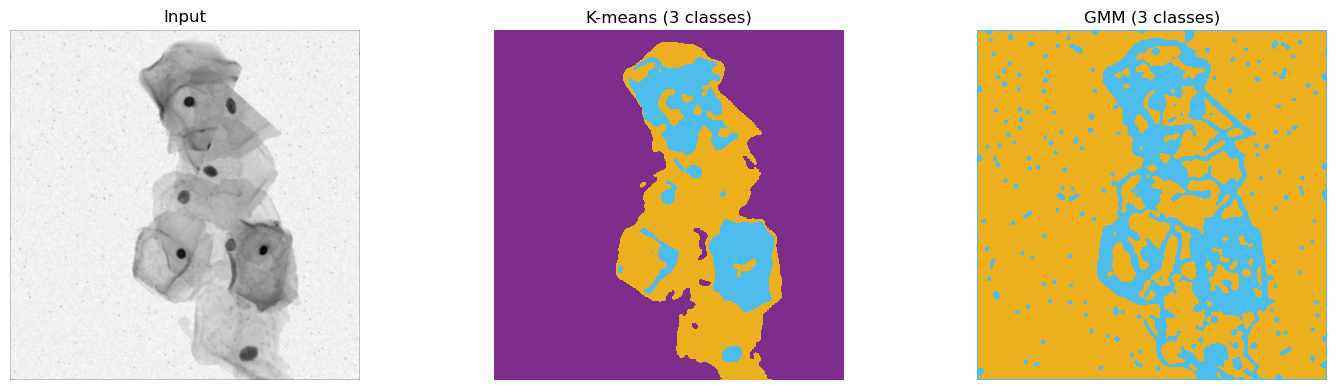

In [45]:
km_mask, gm_mask = segment_image_both(
    image_path=r"../Dataset/Group04-cervical_cytology_images/group04/Test/35.png",
    model_npz_path="models/cell_segmenter_diag.npz",
    patch_size=7,    # must match training
    stride=1,        # must match training
    show=True
)


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define exactly three distinct colors (e.g., blue, orange, green)
cmap3 = ListedColormap([[0.121, 0.466, 0.705],   # class 0
                        [1.000, 0.498, 0.054],   # class 1
                        [0.172, 0.627, 0.172]])  # class 2
norm3 = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap3.N)

def show_three_class_mask(mask, title="Segmentation (3 classes)"):
    # mask values must be 0,1,2 after applying the cluster->class mapping
    plt.figure()
    plt.imshow(mask, cmap=cmap3, norm=norm3, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [36]:
# 1) Features for this image
# F, (H, W) must already be defined from your extractor or test item:
# F: np.ndarray, shape (nh*nw, 2)
# H, W: original image height/width
# patch_size, stride: same as during feature extraction (usually 7, 1)

# 2) Predict with diagonal GMM
gmm_raw = gmm_predict_labels_diag(F, gmm_params)      # uses saved params {"pi","means","vars"}

# 3) Map clusters -> classes
gmm_pred = apply_mapping(gmm_raw, gmm_map)            # gmm_pred now in {0,1,2}

# 4) Reconstruct pixel mask
gm_mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=gmm_pred)

# 5) Visualize with exactly 3 colors (optional)
show_three_class_mask(gm_mask, title="GMM (K=3)")



ValueError: Labels count 256036 != nh*nw 36

In [37]:
print("F.shape:", F.shape, "labels:", gmm_pred.shape)
print("H,W:", H,W, "patch_size:", patch_size, "stride:", stride)
nh = (H - patch_size)//stride + 1
nw = (W - patch_size)//stride + 1
print("nh*nw:", nh*nw)


F.shape: (256036, 2) labels: (256036,)
H,W: 0 0 patch_size: 7 stride: 1
nh*nw: 36


In [39]:
d = np.load(test_npy_path, allow_pickle=True).item()
F = np.asarray(d["features"], dtype=np.float32)      # (256036, 2)
H, W = map(int, d["image_shape"])                    # must be the original image size
patch_size = int(d.get("patch_size", 7))
stride = int(d.get("stride", 1))

gmm_raw = gmm_predict_labels_diag(F, gmm_params)
gmm_pred = apply_mapping(gmm_raw, gmm_map)

nh = (H - patch_size)//stride + 1
nw = (W - patch_size)//stride + 1
assert nh*nw == F.shape[0], f"{nh*nw} != {F.shape[0]}"

mask = segmentation_mask_from_patch_labels(H, W, patch_size=patch_size, stride=stride, labels=gmm_pred)


NameError: name 'test_npy_path' is not defined